pandas-ylt
==========

Python modules for working in pandas with various loss data tables used for CAT modelling


### Read the example YLT

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

from pandas_ylt.yeareventloss import YearEventLossTable
from pandas_ylt.yeareventallocloss import YearEventAllocLossTable
# Define the layers
from pandas_ylt.layer import Layer


yelt = pd.read_csv("tests/_data/example_pareto_poisson_yelt.csv",
                    index_col=['Year', 'EventID', 'DayOfYear'])['Loss']
yelt.attrs['n_yrs'] = 1e5

display(yelt.yel.to_rp_summaries([200, 100, 10], is_ef=False).to_frame().style.format("{:,.0f}"))
display(yelt.yel.to_summary_stats_series().to_frame().style.format("{:,.0f}"))

,Loss
Metric,
AAL,"5,564"
STD,"158,881"


### Applying an example reinsurance tower to the losses

In [2]:
layers = {
    # Layers at 20,000 increments with 1 reinstatement
    "20 xs 20 (1@100)": Layer(
        **{"limit": 20000, "xs": 20000, "agg_limit": 40000.0, "reinst_rate": 0.04}
    ),
    "20 xs 40 (1@100)": Layer(
        **{"limit": 20000, "xs": 40000, "agg_limit": 40000.0, "reinst_rate": 0.02}
    ),
    "20 xs 60 (1@100)": Layer(
        **{"limit": 20000, "xs": 60000, "agg_limit": 40000.0, "reinst_rate": 0.01}
    ),
    "20 xs 80 (1@0)": Layer(
        **{"limit": 20000, "xs": 80000, "agg_limit": 40000.0, "reinst_rate": 0.0}
    ),
}

Get the summary stats for each layer

In [3]:
# Get a separate YLT for each layer
lyr_yelts = {lyr: layers[lyr].yelt_loss(yelt) for lyr in layers}
# lyr_yelts

# Calculate the layer stats from the YLTs
summary_stats = {k: 
 {'AAL': yelt.yel.aal, 
  'STD': yelt.yel.to_ylt().yl.std(),
  'ExpReinst': yelt.yel.to_ylt().clip(upper=(layers[k].max_reinstated_limit)).yl.aal * layers[k].reinst_rate,
  'AttachRP': 1 / yelt.yel.to_ylt().yl.prob_of_a_loss,
  'FullLimitRP': 1 / yelt.yel.to_ylt(is_occurrence=True).yl.loss_exprobs([layers[k].limit])[0],
  'ExhaustRP': 1 / yelt.yel.to_ylt().yl.loss_exprobs([layers[k].agg_limit])[0],
 }
  for k, yelt in lyr_yelts.items()}

# Display the results
pd.DataFrame(summary_stats).T.style.format({"AAL": "{:,.0f}", 'STD': '{:,.0f}', 
                                            'ExpReinst': '{:.1f}', 
                                            'AttachRP': "{:,.0f}",
                                            'FullLimitRP': "{:,.0f}",
                                            'ExhaustRP': "{:,.0f}",            
                                            })

/tmp/ipykernel_7008/1661765216.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  'ExhaustRP': 1 / yelt.yel.to_ylt().yl.loss_exprobs([layers[k].agg_limit])[0],


,AAL,STD,ExpReinst,AttachRP,FullLimitRP,ExhaustRP
20 xs 20 (1@100),336,"2,439",13.4,41,82,"16,667"
20 xs 40 (1@100),201,"1,934",4.0,82,121,"50,000"
20 xs 60 (1@100),144,"1,656",1.4,121,161,"100,000"
20 xs 80 (1@0),114,"1,482",0.0,161,196,inf


Calculate the YLTs net of reinstatement costs. The AAL to the layer is reduced because reinst premiums offset the loss.

In [4]:
lyr_yelts_net_rip = {lyr: layers[lyr].yelt_loss(yelt, net_reinst=True) for lyr in layers}
summary_stats = {k: 
 {'AAL': yelt.yel.aal, 
  'STD': yelt.yel.to_ylt().yl.std(),
 }
  for k, yelt in lyr_yelts_net_rip.items()}

# Display the results
pd.DataFrame(summary_stats).T.style.format({"AAL": "{:,.0f}", 'STD': '{:,.0f}',})

,AAL,STD
20 xs 20 (1@100),323,"2,342"
20 xs 40 (1@100),197,"1,896"
20 xs 60 (1@100),143,"1,640"
20 xs 80 (1@0),114,"1,482"


Get the net and final net EP curve

In [8]:
retained_yelt = yelt.subtract(pd.concat(lyr_yelts.values()).groupby(yelt.index.names).sum(), fill_value=0.0)
net_rip_yelt = yelt.subtract(pd.concat(lyr_yelts_net_rip.values()).groupby(yelt.index.names).sum(), fill_value=0.0)

combined_rp_curves = pd.concat([
    df.yel.to_rp_summary([250, 200, 150, 100, 75, 50, 25, 10], is_ep=True, is_occurrence=True).rename(name)
    for name, df in [('Gross', yelt), ('Net', retained_yelt), ('Final Net', net_rip_yelt)]
], axis=1)


display(combined_rp_curves.style.format("{:,.0f}"))
# display(retained_yelt.yel.to_summary_stats_series().to_frame().style.format("{:,.0f}"))

,Gross,Net,Final Net
ReturnPeriod,,,
250,"123,967","43,967","45,367"
200,"101,450","21,450","22,850"
150,"75,760","20,000","21,355"
100,"49,340","20,000","20,980"
75,"36,257","20,000","20,646"
50,"24,074","20,000","20,163"
25,"12,135","12,135","12,135"
10,"4,708","4,708","4,708"


[None, None, (0.0001, 1)]

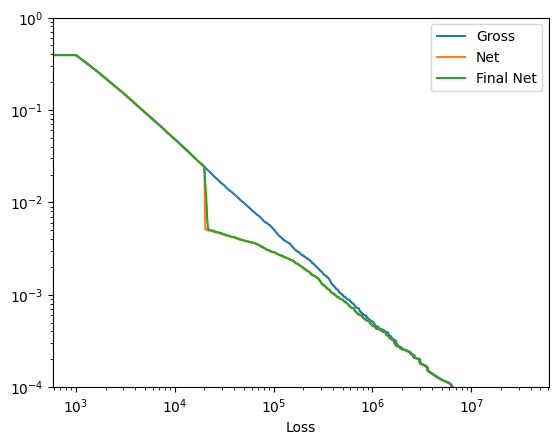

In [17]:
# Make a plot
fig, ax = plt.subplots(1)

for name, df in [('Gross', yelt), ('Net', retained_yelt), ('Final Net', net_rip_yelt)]:
    df.yel.to_ylt(is_occurrence=True).yl.to_ep_curve().plot('Loss', 'ExProb', ax=ax, label=name)

ax.set(xscale='log', yscale='log', ylim=[1e-4, 1], ylabel='Exceedance Probability')
# ax.plot(yelt)

### Define some layers

In [ ]:



layers = [
    # First loss
    {'name': '20 xs 0', 'layer': Layer(**{'limit': 20000, 'xs': 0, 'agg_limit': 20000.0})},    
    {'name': '20 xs 20', 'layer': Layer(**{'limit': 20000, 'xs': 20000, 'agg_limit': 20000.0})},
    {'name': '20 xs 40', 'layer': Layer(**{'limit': 20000, 'xs': 40000, 'agg_limit': 20000.0})},
    {'name': '20 xs 60', 'layer': Layer(**{'limit': 20000, 'xs': 60000, 'agg_limit': 20000.0})},    
    {'name': '20 xs 80', 'layer': Layer(**{'limit': 20000, 'xs': 80000, 'agg_limit': 20000.0})},    
    # Second loss
    {'name': '20 xs 0 reinst', 'layer': Layer(**{'limit': 20000, 'xs': 0, 'agg_limit': 20000.0, 'agg_xs': 20000.0})},        
    {'name': '20 xs 20 reinst', 'layer': Layer(**{'limit': 20000, 'xs': 20000, 'agg_limit': 20000.0, 'agg_xs': 20000.0})},
    {'name': '20 xs 40 reinst', 'layer': Layer(**{'limit': 20000, 'xs': 40000, 'agg_limit': 20000.0, 'agg_xs': 20000.0})},
    {'name': '20 xs 60 reinst', 'layer': Layer(**{'limit': 20000, 'xs': 60000, 'agg_limit': 20000.0, 'agg_xs': 20000.0})}, 
    {'name': '20 xs 80 reinst', 'layer': Layer(**{'limit': 20000, 'xs': 80000, 'agg_limit': 20000.0, 'agg_xs': 20000.0})}, 
]



### Calculate the layer loss

In [ ]:
lyr_yelts = pd.concat([lyr['layer'].yelt_loss(yelt) for lyr in layers], 
                      keys=[lyr['name'] for lyr in layers], names=['Layer'])
lyr_yelts

### Get the AEP and OEP

In [ ]:
ceded_yelt = lyr_yelts.groupby(yelt.index.names).sum()
retained_yelt = yelt.subtract(ceded_yelt, fill_value=0.0)

return_periods = [500, 250, 200, 150, 100, 90, 80, 70, 60, 50, 40, 30, 20, 10]
ep0 = yelt.yel.to_rp_summaries(return_periods)
ep1 = ceded_yelt.yel.to_rp_summaries(return_periods)
ep2 = retained_yelt.yel.to_rp_summaries(return_periods)

pd.concat([ep0, ep1, ep2], axis=1, keys=['Gross', 'Ceded', 'Retained']).style.format("{:,.0f}")

### Get the AAL per layer

In [ ]:
for lyr_name, grp in lyr_yelts.groupby('Layer'):
    print(f"{lyr_name:>20}: {grp.yel.aal:,.0f}")

print(f"{'Retained':>20s}: {retained_yelt.yel.aal:,.0f}")